# Description

Notebook performing the effective sample size simulations for Figure 1 and Figure C.2.

# Imports

In [3]:
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# user imports
import sys
sys.path.append('../src/rdd-discovery')

from utils.neff import *
from utils.pwr import *
from utils.sim import *
from utils.rddd import create_feat_df, test_discontinuity

%load_ext autoreload
%autoreload 2

%matplotlib inline

The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


In [4]:
FIG_PATH = '../figures/'

# Null distribution simulation

In [5]:
tau = 0.5
take = 0.05
cutoff = 0.5
bw = 0.5

def simulation_helper_overlap(seed, n_samples, n_trials=1000):
    """
    Simulation helper for the null distribution of the neff_diff test statistic.

    Generates a population of size n_samples*2, then randomly selects n_samples
    for each group.
    """
    frd_df = gen_fuzzy_rdd_first_stage(n_samples=int(n_samples*2),
                                    fuzzy_gap=tau, 
                                    take=take, 
                                    seed=seed, 
                                    cutoff=cutoff,
                                    use_covars=False)

    test_df = create_feat_df(frd_df, running='x', cutoff=cutoff, bw=bw)
    
    grp1_idx = test_df.index.isin(np.random.choice(test_df.index, n_samples, replace=False))
    grp2_idx = pd.Series(([True] * n_samples) + ([False] * n_samples))

    df = pd.DataFrame()
    df['seed'] = [seed]
    df['group_size'] = [test_df.shape[0]]

    #df['pwr'] = [first_stage_pwr(grp1_idx, test_df)]
    df['grp1_neff'] = [neff(test_df[grp1_idx], treat='t', instr='z')]
    df['grp2_neff'] = [neff(test_df[grp2_idx], treat='t', instr='z')]


    df['tstat'] = [neff_tstat(test_df, grp1_idx, grp2_idx, 
                              treat='t', instr='z',
                              #grp1_tau=grp1_tau, grp2_tau=grp2_tau
                              )]# / np.sqrt(test_df.shape[0]))
    #var_neff.append(neff_var(grp1_idx, test_df))

    # checks on the influence function
    test_df['grp1_indicator'] = grp1_idx.astype(int)
    test_df['grp2_indicator'] = grp2_idx.astype(int)

    assert np.isclose(np.mean(neff_influence(test_df, 'grp1_indicator', treat='t', instr='z')), 0)
    assert np.isclose(np.mean(neff_influence(test_df, 'grp2_indicator', treat='t', instr='z')), 0)

    return df

In [6]:
trial_dict = {}
n_samples = 100
trials = [500, 1000, 2000, 4000]

# switch n_trials with n_samples
for n_trials in tqdm(trials):
    sim_args = [(i, n_samples, n_trials) for i in range(n_trials)]

    with multiprocessing.Pool(12) as pool:
        results = pool.starmap(simulation_helper_overlap, sim_args)

    df = pd.concat(results)
    df['neff_diff'] = df['grp1_neff'] - df['grp2_neff']
    display((df['tstat'] > 1.96).value_counts(normalize=True))    
    trial_dict[n_trials] = df

  0%|                                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]

False    0.968
True     0.032
Name: tstat, dtype: float64

 25%|████████████████████████████████████████████▌                                                                                                                                     | 1/4 [00:03<00:10,  3.65s/it]

False    0.971
True     0.029
Name: tstat, dtype: float64

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2/4 [00:10<00:11,  5.66s/it]

False    0.9715
True     0.0285
Name: tstat, dtype: float64

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3/4 [00:23<00:09,  9.04s/it]

False    0.97325
True     0.02675
Name: tstat, dtype: float64

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.16s/it]


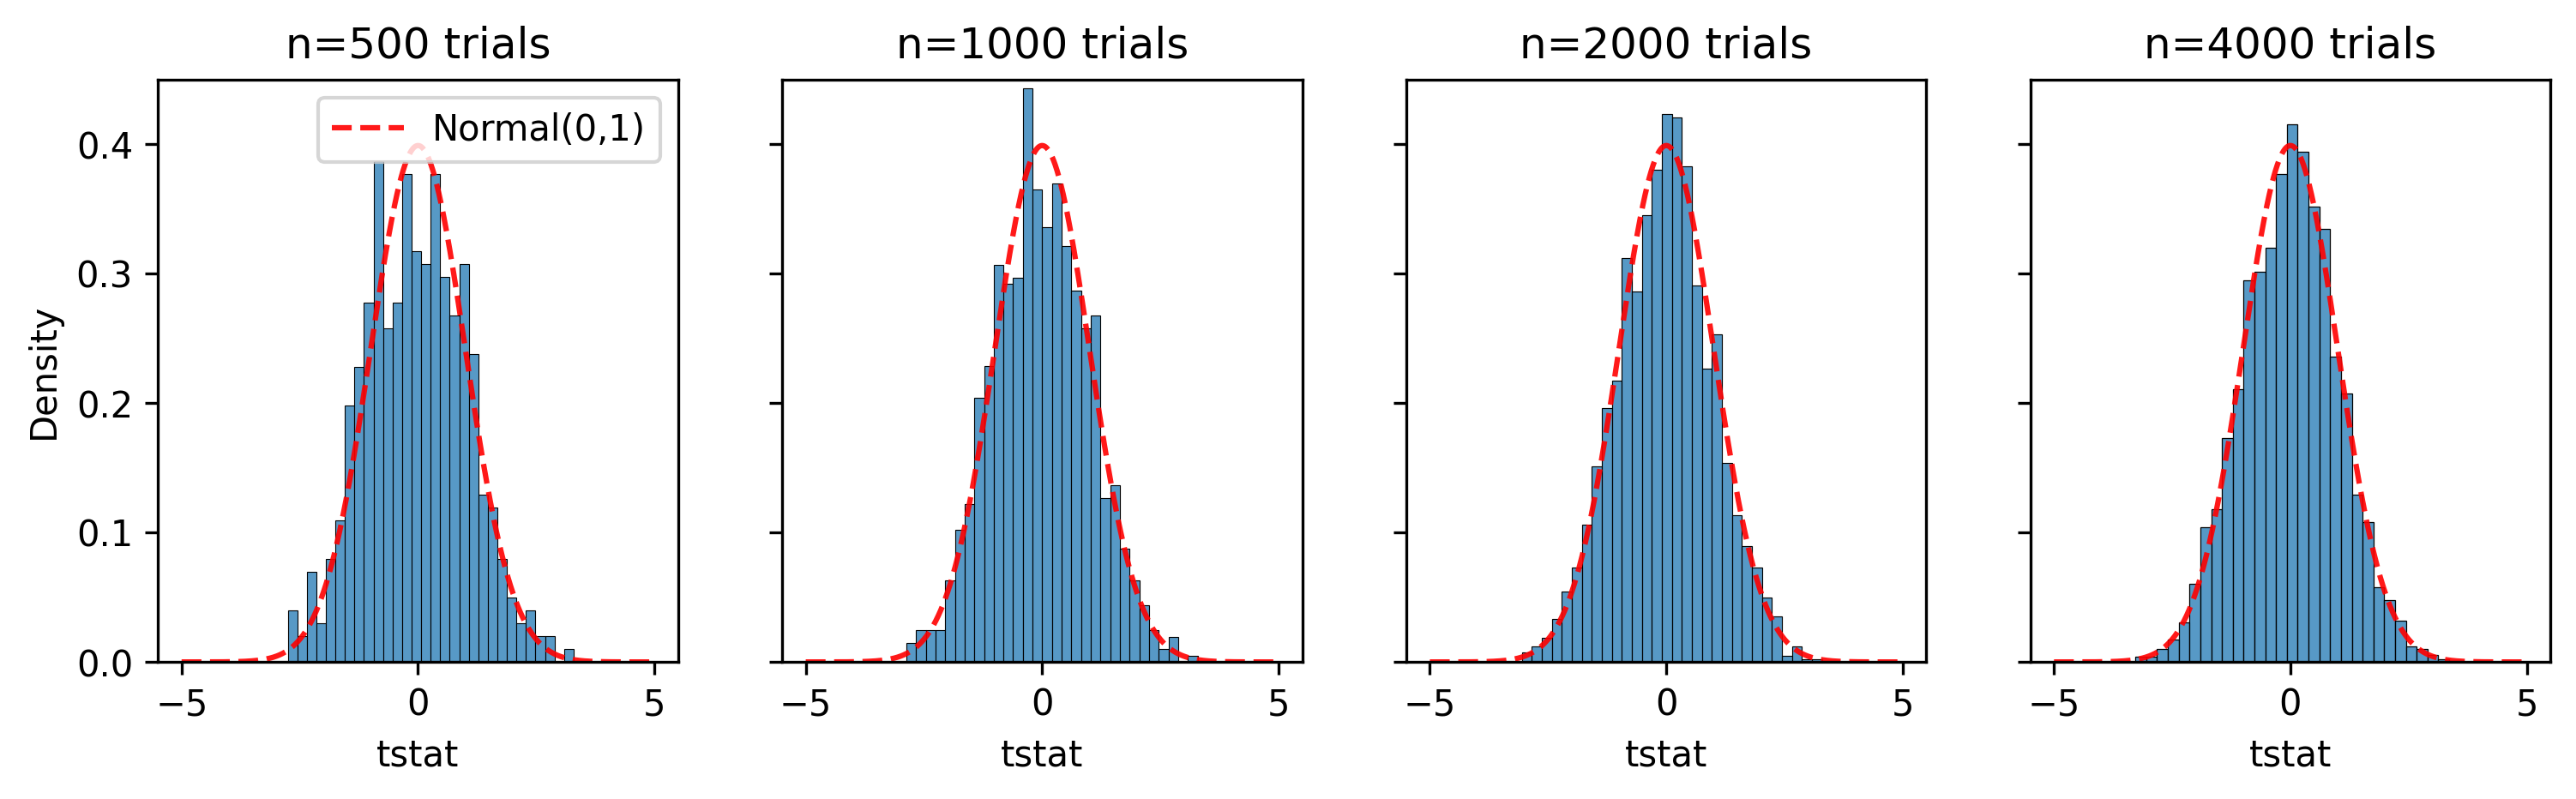

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), dpi=300)

for idx, ax in enumerate(axs.ravel()):
    #x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
    x = np.linspace(-5, 5, 1000)

    ax.plot(x, norm.pdf(x), 'r--', alpha=0.9, label='Normal(0,1)')
    trial = trials[idx]
    df = trial_dict[trial]
    ax.set_title("n={} trials".format(trial))
    ax.set_ylim(0, 0.45)
    sns.histplot(df['tstat'], ax=ax, bins=30, stat='density')

    if idx == 0:
        ax.legend()
    if idx != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    #ax.legend()
fig.patch.set_facecolor('white')
fig.savefig(os.path.join(FIG_PATH, 'null_neff_simulations.png'), dpi=300, bbox_inches='tight')

# Power Comparisons

In [8]:
n_samples = 1000


ts_neff = []
grp_neff = []
pop_neff = []
grp_infl = []
pop_infl = []
pwrs = []
group_size = []
var_neff = []
tau_hats = []
n_trials = 1000
tau = 0.2
seed = 42

np.random.seed(seed)
bw= 0.5

for i in tqdm(range(n_trials)):

    frd_df = gen_fuzzy_rdd_first_stage(n_samples=int(n_samples),
                                    fuzzy_gap=tau, 
                                    take=take, 
                                    seed=i, 
                                    cutoff=cutoff,
                                    use_covars=False)

    test_df = create_feat_df(frd_df, running='x', cutoff=cutoff, bw=bw)
    n = np.random.randint(low=450, high=950)

    group_idx = test_df.index.isin(np.random.choice(test_df.index, n, replace=False))
    grp_df = test_df[group_idx]

    p_lower = grp_df[(grp_df['z'] == 0)]['t'].mean()
    p_upper = grp_df[(grp_df['z'] == 1)]['t'].mean()
    grp_var = first_stage_asymp_var(ptake_lower=p_lower, ptake_upper=p_upper, total_n=test_df.shape[0], n_incl=grp_df.shape[0])
    
    tau_hat = p_upper - p_lower
  
    tau_hats.append(tau_hat)
    group_size.append(grp_df.shape[0])
    
    pwrs.append(rdd_power(tau_hat, grp_var))
    grp_neff.append(neff(test_df[group_idx], treat='t', instr='z'))
    pop_neff.append(neff(test_df[~group_idx], treat='t', instr='z'))
    ts_neff.append(neff_tstat(test_df, group_idx, ~group_idx, treat='t', instr='z'))

    # checks on the influence function
    test_df['pop_indicator'] = (~group_idx).astype(int)
    test_df['grp_indicator'] = group_idx.astype(int)

    grp_infl.append(neff_influence(test_df, 'grp_indicator', treat='t', instr='z'))
    pop_infl.append(neff_influence(test_df, 'pop_indicator', treat='t', instr='z'))

    assert np.isclose(neff_covar(test_df, group_idx, ~group_idx, treat='t', instr='z').values[0,1], 0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.27it/s]


In [9]:
df = pd.DataFrame()
df['grp_neff'] = grp_neff
df['pop_neff'] = pop_neff
df['tstat'] = ts_neff
df['group_size'] = group_size
df['pwr'] = pwrs
df['neff_diff'] = df['grp_neff'] - df['pop_neff']
df['tau_hat'] = tau_hats

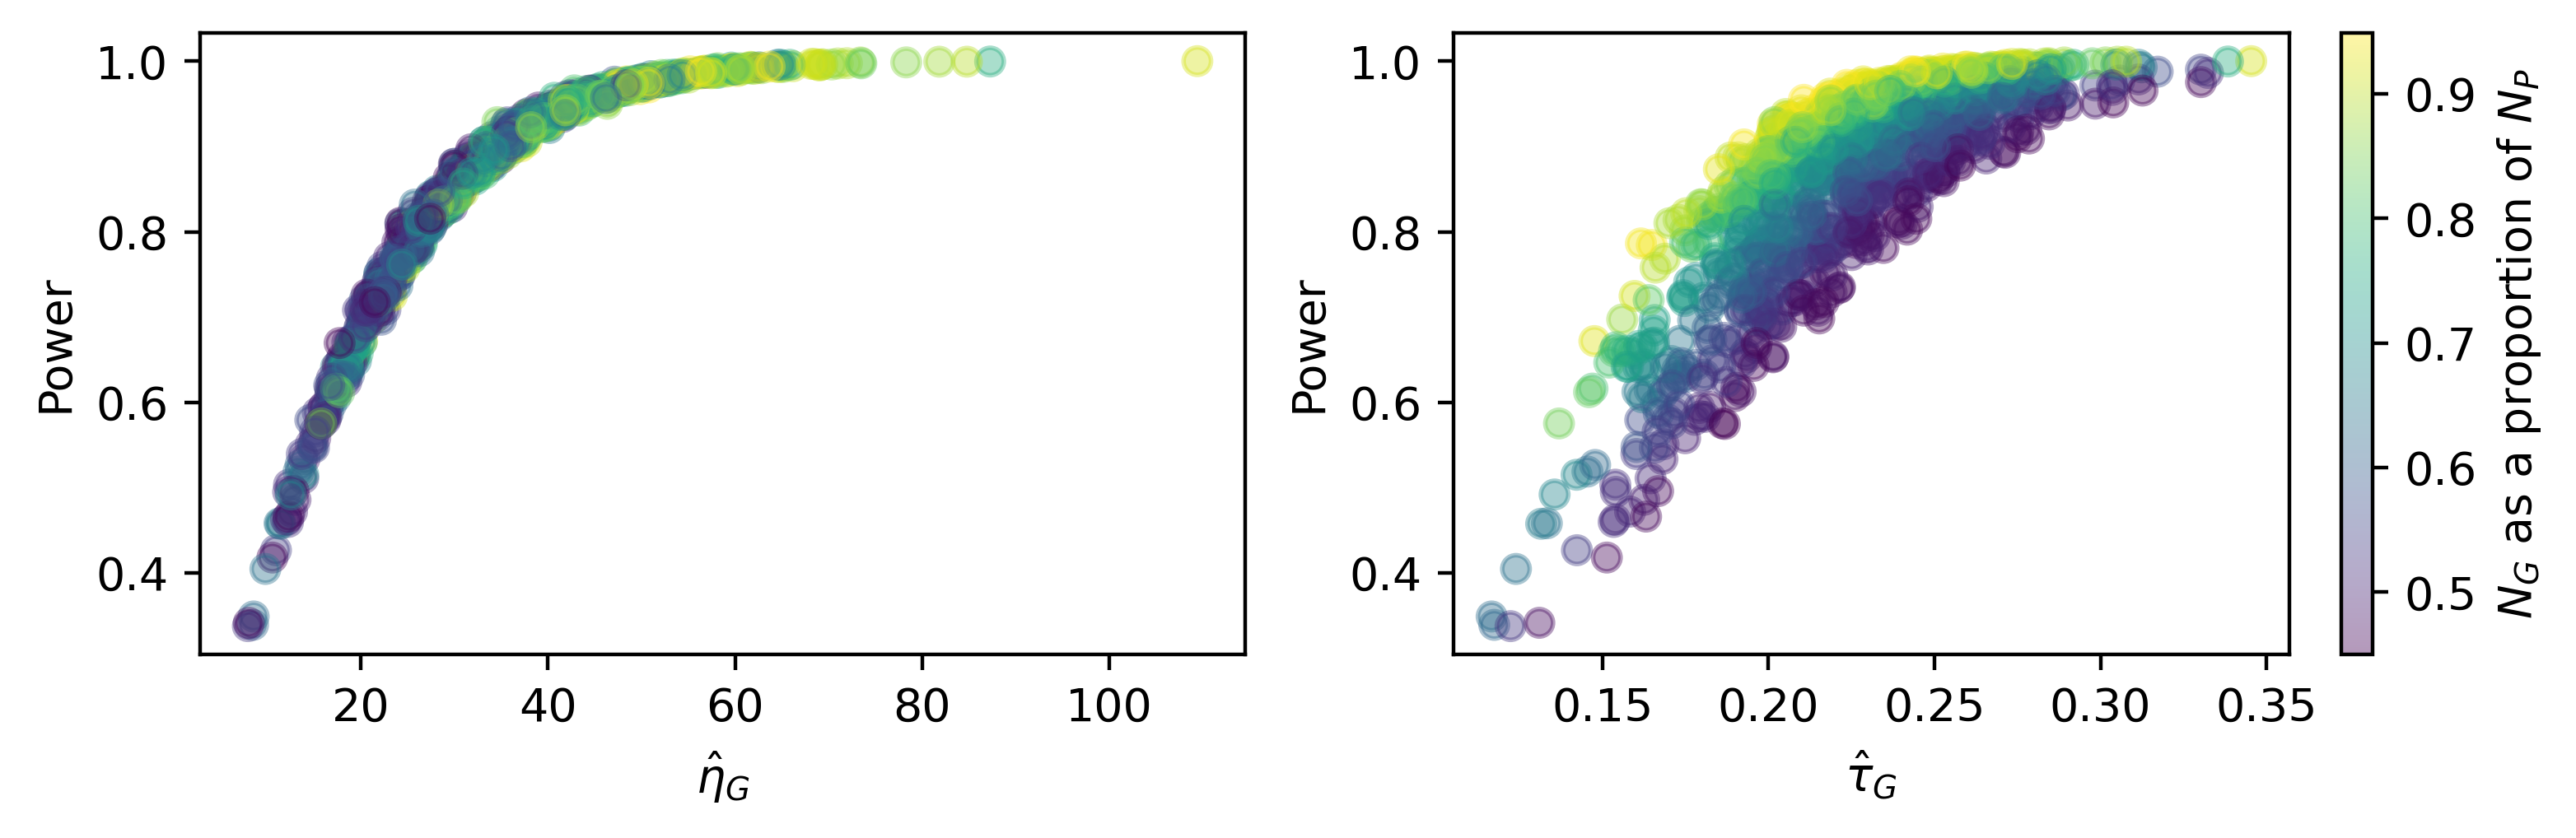

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), dpi=400)

cm = ax1.scatter(x=df['grp_neff'],
                 y=df['pwr'],#r2s,#np.array(std_errs)**2, 
                 alpha=0.4, c=df['group_size'] / n_samples)#, cmap="coolwarm")
#plt.colorbar(cm)
ax1.set_ylabel("Power")
ax1.set_xlabel("$\hat{\\eta}_G$")
#ax1.set_xlim(0.04, 0.36)
fig.patch.set_facecolor('white')
#ax1.set_ylim(0.0, 0.01)
#ax.axhline(y=0.08)
#ax.set_xlim(1.95, 3)

cm = ax2.scatter(x=df['tau_hat'],# / np.array(std_errs),
                y=df['pwr'], alpha=0.4, c=df['group_size'] / n_samples)#, cmap="coolwarm")
plt.colorbar(cm, label="$N_G$ as a proportion of $N_P$")
#plt.colorbar(cm)
#ax2.set_xlim(0.0, 0.4)
ax2.set_ylabel("Power")
ax2.set_xlabel("$\hat{\\tau}_G$")
plt.savefig(os.path.join(FIG_PATH, "neff_pwr.png"), bbox_inches="tight")